**TODO**

<ol>
<li><strike>Check if Note number conversion is correct</strike></li>
<li><strike>Create a tonic dict for existing makamlar</strike></li>
<li>Relation between measures are indicated how? (Extensions, glissando, my vocab is poor here)</li>
<li>Deal with Multi-part scores. Probably not possible in makam music</li>
</ol>

**STATISTICS**

<ol>
<li><strike>Note histogram (octave folded, just 53-TET pitch class) Christos</strike></li>
<li><strike>Melodic line plot Christos</strike></li>
<li><strike>Return to tonic durations (how many notes did it take to return to tonic) OGUZ</strike></li> 
    <li><strike>Average length for all makams in a single plot OGUZ</strike></li> 
<li><strike>Return to tonic pitch ranges (what pitch range did the return to tonic cover) OGUZ</strike></li> 
<li><strike>General note range</strike>Christos</li>
<li>Histogram of note durations Oguz</li> 
<li>Histogram of position of tonic in measure (normalized) Christos</li> 
<li>Interval histogram Christos</li>
<li>Note duration</li>

**Discoveries**
   - Alter<br>
"-1, -4, -5, -8, +1, +4, +5, +8" Comma alterations of the accidentals in the 53 Comma Scale.
   - "divisions" attribute<br>
https://github.com/burakuyar/MusicXMLConverter/blob/master/musicxmlconverter/symbtr2musicxml.py
                measure_len = (temp_num_beats * num_divs *
                           4 / float(temp_beat_type))

**Questions**              

- RESEARCH QUESTION: What are other components of Turkish makam music that define the makam?

- Can makam music have time signature change?
- Is makam music actually strictly following the theoretical tonic for a specific makam?



```Measure
    0: attributes ( even if no note is present) 
        sometimes empty, o.w.
        'divisions'
        'key'
        'time'
    1,.. notes ```

![alt text](fig1.png "Title")

In [1]:
PITCH_CLASS = {
        'C':0,
        'D':9,
        'E':18,
        'F':22,
        'G':31,
        'A':40,
        'B':44
}

ACCIDENTALS = {
        'quarter-flat':-1,
        'slash-flat':-4,
        'flat':-5,
        'double-slash-flat':-8,
        'natural': 0,
        'quarter-sharp':+1,
        'sharp':+4,
        'slash-quarter-sharp':+5,  
        'slash-sharp':+8
}

# a tonic reference https://www.researchgate.net/figure/Twenty-four-makams-that-appear-in-this-paper-are-represented-in-the-AEU-system-Special_fig2_276132262
# for those not in the paper, cross-referenced from recordings and other sources e.g. http://muzik.name/
TONICS = {
        'Uşşak': PITCH_CLASS['G'],
        'Nihâvent': PITCH_CLASS['G'],
        'Kürdîlihicazkâr': PITCH_CLASS['D'],
        'Sabâ': PITCH_CLASS['D'],
        'Rast': PITCH_CLASS['C'],
        'Mâhur': PITCH_CLASS['G'],
        'Segâh': PITCH_CLASS['A'] + ACCIDENTALS['sharp'],
        'Hicaz': PITCH_CLASS['G'],
        'Hüseynî': PITCH_CLASS['G'],
        'Bûselik': PITCH_CLASS['G'] + ACCIDENTALS['sharp'],
        'Muhayyer': PITCH_CLASS['G'],
        'Hüzzam': PITCH_CLASS['A'],
        'Hicazkâr': PITCH_CLASS['F'] + ACCIDENTALS['sharp'],
        'Beyâtî': PITCH_CLASS['G'],
        'Karcığar': PITCH_CLASS['A'],
        'Acemaşîrân': PITCH_CLASS['F']
}

In [2]:
# Code modified from https://github.com/burakuyar/Tools/blob/master/musicxml_player.py
# Data from https://github.com/sertansenturk/SymbTr

import os
import glob
from collections import defaultdict, Counter

import numpy as np
from scipy import stats

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

DATA_DIR=os.path.join(os.getcwd(), 'data')
#DATA_DIR = '/home/chris/Documents/makam_MusicXML'

In [3]:
def read_score(score_path):
    tree=ET.parse(score_path)
    root=tree.getroot()
    return root

def get_composer_info(root):
    composition_name=root.find('work/work-title').text
    composer_name=root.find('identification/creator').text
    return composition_name,composer_name 

def get_makam_form_usul(root):
    makam_form_usul=root.find('part/measure/direction/direction-type/words').text.split(', ')
    makam=makam_form_usul[0].split(': ')[-1]
    form=makam_form_usul[1].split(': ')[-1]
    usul=makam_form_usul[2].split(': ')[-1][:-1]
    return makam, form, usul

def note_to_number(p,o,a):
    """Convert NoteAEU to AEU53 Comma numbering. """
    if p!='Rest':
        return 53*(int(o)+1) + PITCH_CLASS[p] + ACCIDENTALS[a]
    else:
        return -1

def parse_notes(root, record_embellishment=True):
    """
    Returns a 2D array of [[measure_idx,note_idx,note_duration,note_number, *note_name]]
    Note name can only be "PitchClass Octave", "PitchClass Octave Accidental" or "Rest"
    If a note_name is not Rest and it has zero duration, that note is an embellishment.
    """
    notes=[]
    for m_idx,measure in enumerate(root.findall('part/measure')):   
        if len(measure.findall('note'))>0: # Check if the measure contains at least one note
            grace_count=0 # Count grace notes in case you don't want to record them
            for n_idx,note in enumerate(measure.findall('note')):
                dur=note.find('duration')
                if dur is None:
                    if not record_embellishment:
                        grace_count+=1
                        continue # skip the grace note
                    else:
                        dur='0' # Embellishment/Grace Note
                else:
                    dur=dur.text
                step=note.find('pitch/step')
                if step is not None:
                    step=step.text
                    octave=note.find('pitch/octave').text
                    acc = note.find('accidental')
                    if acc is None:
                        n=[step,octave,'natural']
                    else:
                        n=[step,octave,acc.text]
                else:
                    rest = note.find('rest')
                    assert rest is not None, "The note doesn't have a pitch and is not a rest!"
                    n=['Rest','','']
                note_number=note_to_number(*n)
                note = [m_idx, n_idx-grace_count, dur, note_number, *n]
                notes.append(note)
    return np.array(notes)

def get_time_signatures(root):
    """Returns all time signatures in the score as a list of tupples.
    Assumes it is possible to have time change in makam pieces."""
    beats = [t.text for t in root.findall('part/measure/attributes/time/beats')]
    types = [t.text for t in root.findall('part/measure/attributes/time/beat-type')]
    all_time_signatures=[(int(b),int(t)) for b,t in zip(beats,types)]
    return all_time_signatures

def get_bpm(root):
    return float(root.find('part/measure/direction/sound').attrib['tempo'])

def get_divisions(root):
    return float(root.find('part/measure/attributes/divisions').text)

def find_key_signature_accidentals(root):
    notes, accidentals = [], []
    for k in root.iter('key'):
        for ks in k.findall('key-step'):
            notes.append(ks.text)
        for ka in k.findall('key-accidental'):
            accidentals.append(ka.text)
    return ['{} {}'.format(n,k) for n,k in zip(notes,accidentals)]

def find_all_accidentals(root):
    return set([a.text for a in root.iter('accidental')])

def get_measure_change_indices(composition):
    """Returns the indices of notes in the composition where the next measure begins."""
    measure_indices=composition['notes'][:,0].astype(int)
    measure_changes=np.insert(np.where(np.diff(measure_indices, prepend=0))[0],0,0)
    return measure_changes

def find_return_to_tonic_durations(composition):
    """Find out how many notes it took between two tonic apppearances"""
    note_array=composition['notes'][:,3].astype(int)
    tonic_positions=np.where((note_array%53)==composition['tonic'])[0]
    return_to_tonic_durations=np.diff(tonic_positions)
    return return_to_tonic_durations

def find_return_to_tonic_ranges(piece):
    """Excluding the rests, finds out the pitch range between each tonic appearances."""
    note_array=piece['notes'][:,3].astype(int)
    note_array=note_array[note_array!=-1] # remove rests for calculating pitch range
    tonic_positions=np.where((note_array%53)==piece['tonic'])[0]    
    ranges=[]
    for i in range(len(tonic_positions)-1):
        s_idx, e_idx = tonic_positions[i],tonic_positions[i+1]
        tonic=note_array[s_idx] # each note segment starts with a T-53, T, or T+53
        between_two_tonics=note_array[s_idx+1:e_idx] # exclude the tonic
        between_two_tonics-=tonic # center around zero
        if between_two_tonics.size>0:
            if np.all(between_two_tonics>0): # If all notes greater than tonic
                max_note=between_two_tonics.max()
                min_note=0
            elif np.all(between_two_tonics<0): # If all notes smaller than tonic
                max_note=0
                min_note=between_two_tonics.min()
            else: # Up and down
                max_note=between_two_tonics.max()
                min_note=between_two_tonics.min()
            ranges.append(max_note-min_note)
    return ranges

def sort_dict_by_key(dct):
    return {k:dct[k] for k in sorted(dct.keys())}

# -> Find all xml files in the DATA_DIR

In [4]:
score_paths = glob.glob(DATA_DIR+'/*.xml')
print(f'There are {len(score_paths)} scores in the directory.')

There are 2200 scores in the directory.


# -> Process

### --> Process 1 XML File

In [5]:
# Read one xml file to a tree structure
score_path=score_paths[0]
root=read_score(score_path)

In [6]:
# Get necessary information
composition_name,composer_name =get_composer_info(root)
print(f'Composition: {composition_name}')
print(f'Composer: {composer_name}')
makam,form,usul=get_makam_form_usul(root)
print(f'Makam: {makam}')
print(f'Form: {form}')
print(f'Usul: {usul}')
time_signatures=get_time_signatures(root)
print(f'Time Signature(s): {time_signatures}')
bpm=get_bpm(root)
print(f'BPM: {bpm}')
divs=get_divisions(root)
print(f'Divisions: {divs}')
key_signature_accidentals=find_key_signature_accidentals(root)
print(f'Accidental(s) in the key signature: {key_signature_accidentals}')
notes=parse_notes(root, record_embellishment=False)

Composition: Bir Melek-Sîma Peri Gördüm
Composer: Hacı Ârif Bey
Makam: Uşşak
Form: Şarkı
Usul: Aksak
Time Signature(s): [(9, 8)]
BPM: 60.0
Divisions: 96.0
Accidental(s) in the key signature: ['B quarter-flat']


In [7]:
print('Meas Pos Dur  Num   STE Oct  Acc')
print('='*len('Meas Pos Dur  Num   STE Oct  Acc'))
for n in notes:
    print(n)   

Meas Pos Dur  Num   STE Oct  Acc
['0' '0' '96' '-1' 'Rest' '' '']
['0' '1' '72' '296' 'G' '4' 'natural']
['0' '2' '24' '305' 'A' '4' 'natural']
['0' '3' '96' '305' 'A' '4' 'natural']
['0' '4' '96' '318' 'C' '5' 'natural']
['0' '5' '24' '318' 'C' '5' 'natural']
['0' '6' '24' '308' 'B' '4' 'quarter-flat']
['1' '0' '36' '308' 'B' '4' 'quarter-flat']
['1' '1' '12' '305' 'A' '4' 'natural']
['1' '2' '24' '296' 'G' '4' 'natural']
['1' '3' '24' '305' 'A' '4' 'natural']
['1' '4' '24' '308' 'B' '4' 'quarter-flat']
['1' '5' '24' '305' 'A' '4' 'natural']
['1' '6' '24' '327' 'D' '5' 'natural']
['1' '7' '24' '318' 'C' '5' 'natural']
['1' '8' '24' '318' 'C' '5' 'natural']
['1' '9' '24' '308' 'B' '4' 'quarter-flat']
['1' '10' '24' '308' 'B' '4' 'quarter-flat']
['1' '11' '24' '305' 'A' '4' 'natural']
['1' '12' '48' '305' 'A' '4' 'natural']
['1' '13' '48' '296' 'G' '4' 'natural']
['1' '14' '24' '308' 'B' '4' 'quarter-flat']
['1' '15' '24' '305' 'A' '4' 'natural']
['2' '0' '96' '305' 'A' '4' 'natural']
[

### --> Process All XML Files

In [8]:
# Create a dictionary containing all the necessary information.
dataset=defaultdict(list)
for score_path in score_paths:
    root=read_score(score_path)
    makam,form,usul=get_makam_form_usul(root)
    composition_name,composer_name =get_composer_info(root)
    score_dict={'composition': composition_name,
                'composer': composer_name,
                'makam': makam,
                'form': form,
                'usul': usul,
                'time_signatures': get_time_signatures(root),
                'bpm': get_bpm(root),
                'divs': get_divisions(root),
                'key_sigsnature_accidentals': find_key_signature_accidentals(root),
                'notes': parse_notes(root, record_embellishment=False)
                }
    dataset[makam].append(score_dict)
print('Number of scores for each makam:')
for makam,dct in dataset.items():
    print(f'{makam}: {len(dct)}')    

Number of scores for each makam:
Uşşak: 118
Nikrîz: 25
Hüzzam: 96
Nihâvent: 130
Muhayyer: 67
Hicaz: 157
Sûzidilârâ: 7
Şerefnümâ: 1
Segâh: 92
Sûzinâk-Zirgüle: 26
Eviç: 34
Şevk-ı-Dil: 2
Rast: 109
Hicazkâr: 79
Tâhir: 31
Hisarbûselik: 20
Kürdîlihicazkâr: 70
Mâhur: 88
Karcığar: 53
Isfahân: 20
Sabâ: 66
Acemkürdî: 37
Dilnişîn: 1
Bûselik: 57
Yegâh: 22
Sultânîyegâh: 22
Beyâtî: 62
Rûy-i-Dilârâ: 1
Hüseynî: 92
Beste-Isfahan: 3
Büzürk: 2
Nihâvend-i-Rûmî: 1
Nişâburek: 26
Segâh-Mâye: 4
Pesendîde: 4
Müstear: 6
Tâhirbûselik: 3
Hicaz-Zirgüle: 7
Hicaz-Hümâyûn: 38
Rûy-i-Irâk: 2
Ferahfezâ: 17
Hicaz-Uzzâl: 12
Şevk'efzâ: 11
Sûzidil: 19
Nevâ: 21
Bestenigâr: 13
Acemaşîrân: 63
Şehnâzbûselik: 8
Kürdî: 14
Hicazaşîrân: 3
Çargâh: 2
Canfezâ: 2
Şehnâz: 25
Evcârâ: 9
Muhayyerkürdî: 32
Beyâtî-Arabân: 7
Sûzinâk: 19
Zâvil: 9
Nihâvend-i-Kebîr: 2
Ferahnümâ: 4
Şedarabân: 15
Dilkeşhâveran: 4
Irak: 5
Pençgâh-ı-Zâid: 2
Çargâh(Yeni): 7
Hüseynîaşîrân: 5
Acem: 7
Nev'eser: 8
Rast-ı-Cedîd: 1
Nühüft: 3
Müberka: 1
Gerdâniye: 26
Sabâ-Z

In [9]:
# Remove makamlar without enough scores
THRESHOLD=50
subset={k:v for k,v in dataset.items() if len(v)>=THRESHOLD}
count=0
for makam, dct in subset.items():
    print(f'{makam}: {len(dct)}')
    count += len(dct)
print("Number of makamlar:", len(subset))
print("Valid score count:", count)

Uşşak: 118
Hüzzam: 96
Nihâvent: 130
Muhayyer: 67
Hicaz: 157
Segâh: 92
Rast: 109
Hicazkâr: 79
Kürdîlihicazkâr: 70
Mâhur: 88
Karcığar: 53
Sabâ: 66
Bûselik: 57
Beyâtî: 62
Hüseynî: 92
Acemaşîrân: 63
Number of makamlar: 16
Valid score count: 1399


In [10]:
# Put the tonics for these makamlar
for makam, makam_dct in subset.items():
    for composition in makam_dct:
        tonic=TONICS[makam]
        composition['tonic']=tonic

In [11]:
single_makam=subset['Muhayyer']
composition=single_makam[0]
composition

{'composition': 'Üç Kardeştik',
 'composer': 'Celal Güzelses',
 'makam': 'Muhayyer',
 'form': 'Türkü',
 'usul': 'Nîmsofyan',
 'time_signatures': [(2, 4)],
 'bpm': 93.0,
 'divs': 96.0,
 'key_sigsnature_accidentals': ['B quarter-flat', 'F sharp'],
 'notes': array([['0', '0', '96', ..., 'A', '5', 'natural'],
        ['0', '1', '48', ..., 'F', '5', 'sharp'],
        ['0', '2', '48', ..., 'G', '5', 'natural'],
        ...,
        ['125', '4', '48', ..., 'B', '4', 'quarter-flat'],
        ['125', '5', '48', ..., 'A', '4', 'natural'],
        ['126', '0', '192', ..., 'A', '4', 'natural']], dtype='<U21'),
 'tonic': 31}

In [12]:
# Find all the note numbers and obsere if a number corresponds to multiple names
# Due to the problems in the theory, we expect not seeing a 1-1 correspondance
check=defaultdict(set)
for makam_dict in dataset.values():
    for composition in makam_dict:
        for row in zip(composition['notes'][:,-4:]):
            n,p,o,a=row[0]
            check[n].add(f'{p}{o} {a}')
check = {k: check[k] for k in sorted(check)}
check

{'-1': {'Rest '},
 '243': {'G3 natural'},
 '251': {'B3 flat'},
 '252': {'A3 natural'},
 '255': {'B3 quarter-flat'},
 '256': {'B3 natural'},
 '265': {'C4 natural'},
 '269': {'C4 sharp'},
 '274': {'D4 natural'},
 '278': {'D4 sharp', 'E4 flat'},
 '279': {'E4 slash-flat'},
 '282': {'E4 quarter-flat'},
 '283': {'E4 natural'},
 '287': {'E4 sharp', 'F4 natural'},
 '288': {'E4 slash-quarter-sharp', 'F4 quarter-sharp'},
 '291': {'F4 sharp'},
 '292': {'F4 slash-quarter-sharp', 'G4 slash-flat'},
 '295': {'G4 quarter-flat'},
 '296': {'G4 natural'},
 '300': {'A4 flat', 'G4 sharp'},
 '301': {'A4 slash-flat', 'G4 slash-quarter-sharp'},
 '304': {'A4 quarter-flat', 'B4 flat'},
 '305': {'A4 natural', 'B4 slash-flat'},
 '308': {'B4 quarter-flat'},
 '309': {'A4 sharp', 'B4 natural'},
 '313': {'A4 slash-sharp', 'B4 sharp'},
 '314': {'C5 slash-flat'},
 '317': {'C5 quarter-flat'},
 '318': {'C5 natural'},
 '322': {'C5 sharp', 'D5 flat'},
 '323': {'C5 slash-quarter-sharp', 'D5 slash-flat'},
 '326': {'C5 slash-

In [13]:
# Get the notes of each measure, disregard note lengths
measure_changes = get_measure_change_indices(composition)
for i in range(len(measure_changes[:-1])):
    measure_notes = composition['notes'][measure_changes[i]:measure_changes[i+1],3]
    print(f'Measure: {i}')
    print(measure_notes)
    print()

Measure: 0
['322' '327' '-1' '305' '327' '327' '322' '327' '336' '340' '336' '327']

Measure: 1
['322' '305' '305' '336' '327' '322' '322' '305' '305' '305' '305' '305'
 '322' '327' '322' '305']

Measure: 2
['305' '336' '336' '327' '322' '327' '336' '336' '340' '336' '340' '336'
 '327']

Measure: 3
['336' '336' '327' '349' '340' '336' '336' '327' '327' '322' '327' '-1']

Measure: 4
['336' '336' '327' '322' '327' '336' '349' '344' '349']

Measure: 5
['344' '336' '341' '336' '327' '340' '336' '327' '322' '305' '336' '327'
 '322' '305' '322' '305']

Measure: 6
['305' '318' '-1' '318' '318' '318' '309' '318' '327' '336' '327' '318'
 '309' '305']



# -> Score statistics

### --> Note histogram

In [14]:
# store aggregate histograms for pieces belonging to makam
# note_histograms[makam_name] = 1x53 np.array
note_histograms = {}
for makam, pieces in subset.items():
    note_histograms[makam] = np.zeros(53, dtype=np.int64)
    for piece in pieces:
        # extract column of index 3 (note value)
        notes = piece['notes'][:, 3].astype(np.int64)
        # remove rests
        notes = notes[notes != -1]
        # octave fold
        for i in range(notes.shape[0]):
            notes[i] = notes[i] % 53       
        # extract and add histogram
        note_histograms[makam] += np.histogram(notes, 
                                               bins=53,
                                               density=False)[0]

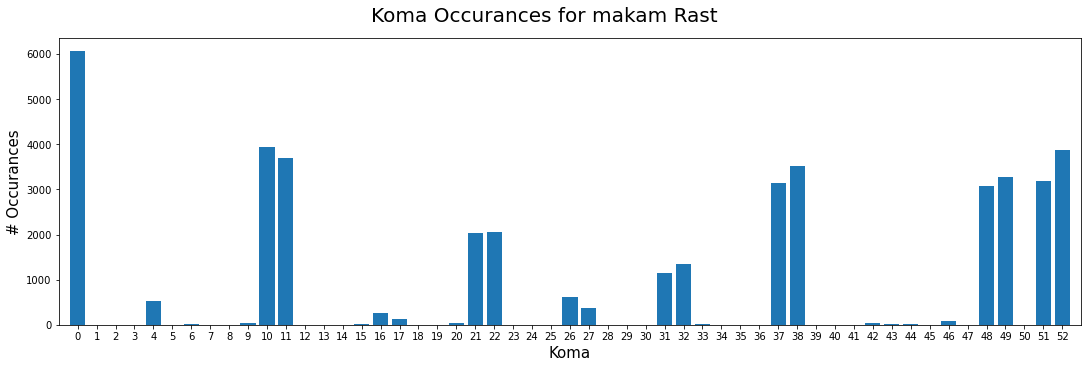

In [15]:
note_idx=np.arange(53)

makam='Rast'
fig,ax = plt.subplots(figsize=(15, 5),constrained_layout=True)
fig.suptitle(f'Koma Occurances for makam {makam}',fontsize=20)
ax.bar(x=note_idx, height=note_histograms[makam])
ax.set_xticks(note_idx)
ax.set_xlabel('Koma', fontsize=15)
ax.set_ylabel('# Occurances', fontsize=15)
ax.set_xlim([-1,53])
plt.show()

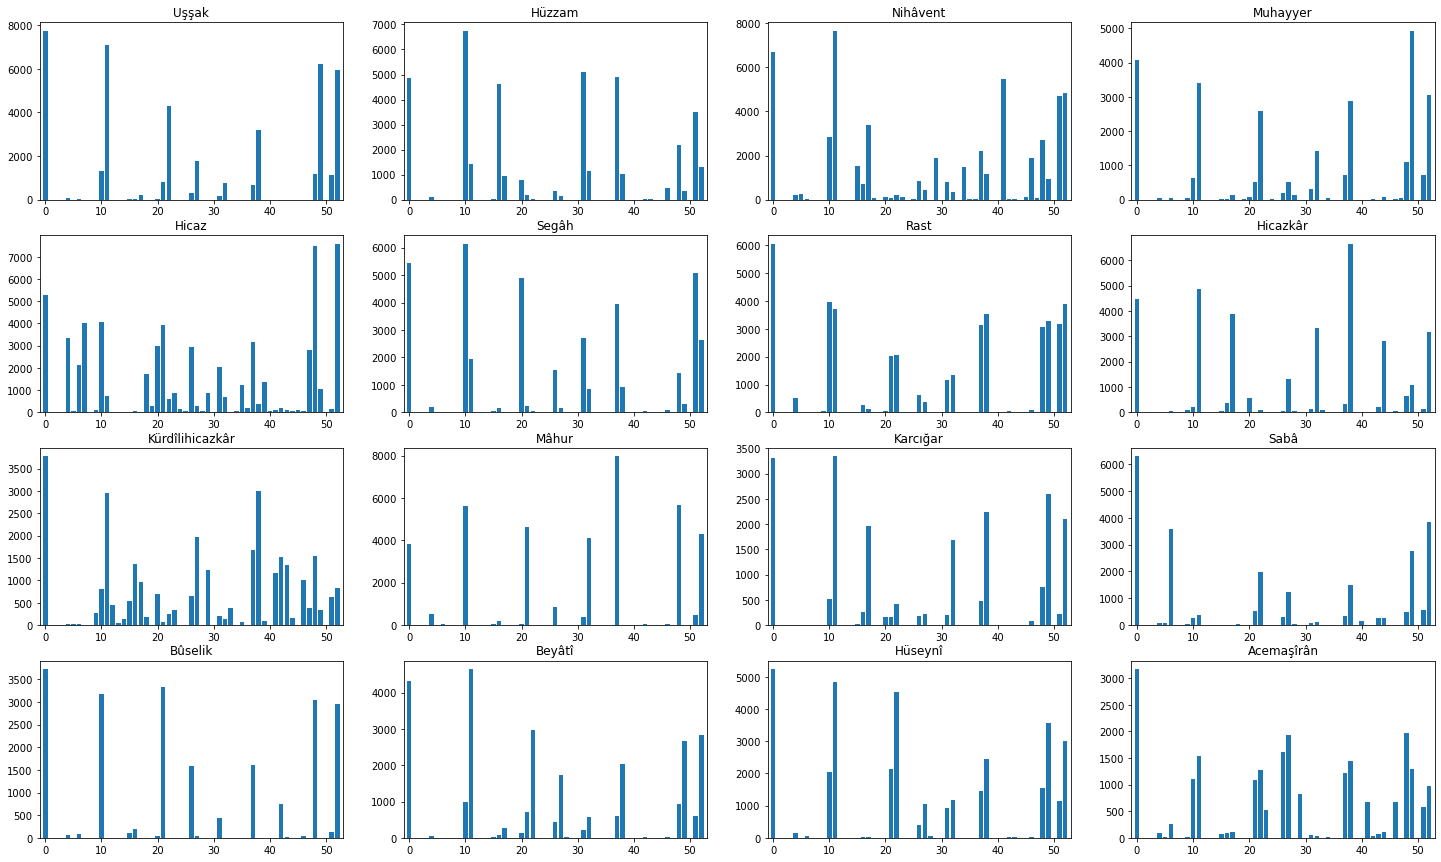

In [16]:
makamlar_names = list(subset.keys())
fig, axs = plt.subplots(4, 4, figsize = (25, 15))
for i in range(4):
    for j in range(4):
        makam_name = makamlar_names[(i*4)+j]
        axs[i][j].bar(x=note_idx, height=note_histograms[makam_name])
        axs[i][j].set_title(makam_name)
        axs[i][j].set_xlim([-1,53])

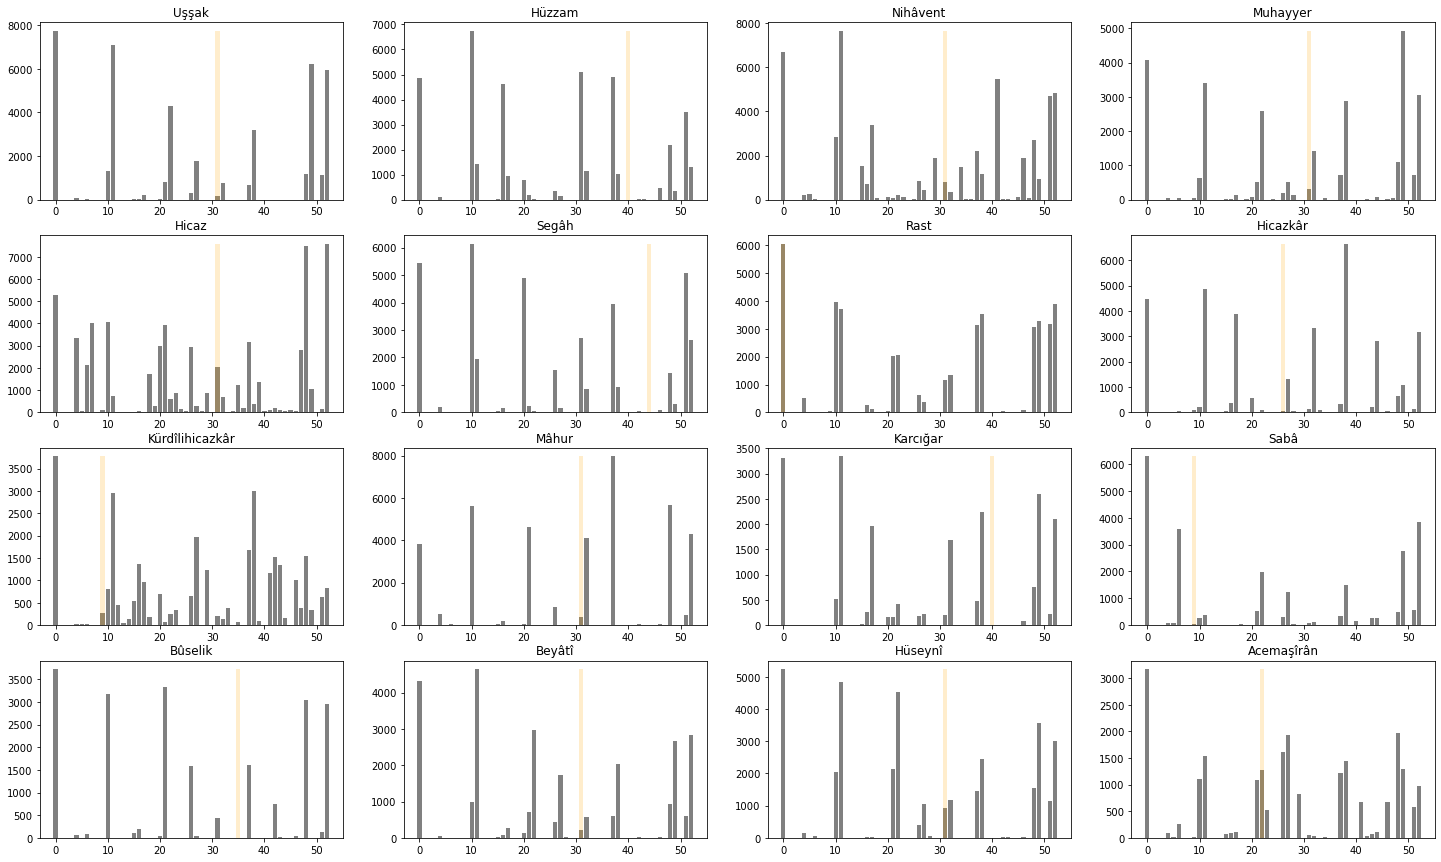

In [17]:
# wouldn't it be interesting to compare the presence of the theoretical tonic?
makamlar_names = list(subset.keys())
fig, axs = plt.subplots(4, 4, figsize = (25, 15))
for i in range(4):
    for j in range(4):
        makam_name = makamlar_names[(i*4)+j]

        # get maximum height from histogram
        max_height = np.amax(note_histograms[makam_name])

        # create array of zeros, with max_height at the tonic
        tonic_array = np.zeros(53)
        tonic_array[TONICS[makam_name]] = max_height

        # plot note histogram
        axs[i][j].bar(x=note_idx, height=note_histograms[makam_name], color='grey', alpha=1)
        axs[i][j].set_title(makam_name)

        # plot tonic
        axs[i][j].bar(x=note_idx, height=tonic_array, color='orange', alpha=0.2)


### --> Melodic lines

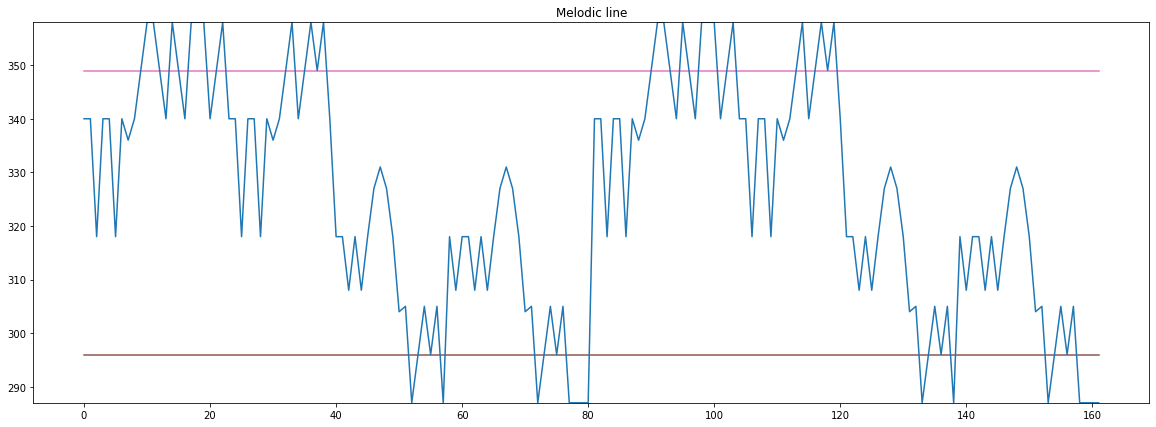

In [18]:
makam_name = 'Muhayyer'
piece_index = 0

def get_melodic_line(notes):
    values = piece['notes'][:, 3].astype(np.int64)
    values = values[values != -1]
    return values

plt.figure(figsize=(20, 7))
melodic_line = get_melodic_line(subset[makam_name][piece_index]['notes'])
tonic_lines = np.zeros((10, len(melodic_line)))
for i in range(10):
    for j in range(len(melodic_line)):
        tonic_lines[i][j] = TONICS[makam_name] + 53*i
    plt.plot(tonic_lines[i])
plt.plot(melodic_line)
plt.title("Melodic line")
plt.ylim(ymin=np.amin(melodic_line), ymax=np.amax(melodic_line))
plt.show()

### --> Note ranges

In [19]:
note_mins = {}
note_maxs = {}

for makam, pieces in subset.items():
    note_mins[makam] = 0
    note_maxs[makam] = 0
    for piece in pieces:
        # extract column of index 3 (note value)
        notes = piece['notes'][:, 3].astype(np.int64)
        # remove rests
        notes = notes[notes != -1]
        # get min and max
        note_mins[makam] += np.amin(notes)
        note_maxs[makam] += np.amax(notes)
    # take average
    note_mins[makam] = note_mins[makam] / len(pieces)
    note_maxs[makam] = note_maxs[makam] / len(pieces)

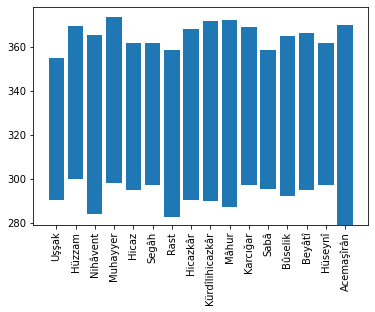

In [20]:
fig, ax = plt.subplots()
mins = np.asarray(list(note_mins.values()))
maxs = np.asarray(list(note_maxs.values()))
diff = maxs-mins

plt.bar(range(0, 16), diff, bottom=mins, width=0.8)
plt.xticks(range(0, 16), rotation=90)
ax.set_xticklabels(makamlar_names)
plt.show()

### Return to Tonic Durations

In [21]:
return_to_tonic_durations=defaultdict(Counter)
for makam, makam_dct in subset.items():
    for composition in makam_dct:
        durations=find_return_to_tonic_durations(composition)
        return_to_tonic_durations[makam]+=Counter(durations.reshape(-1))

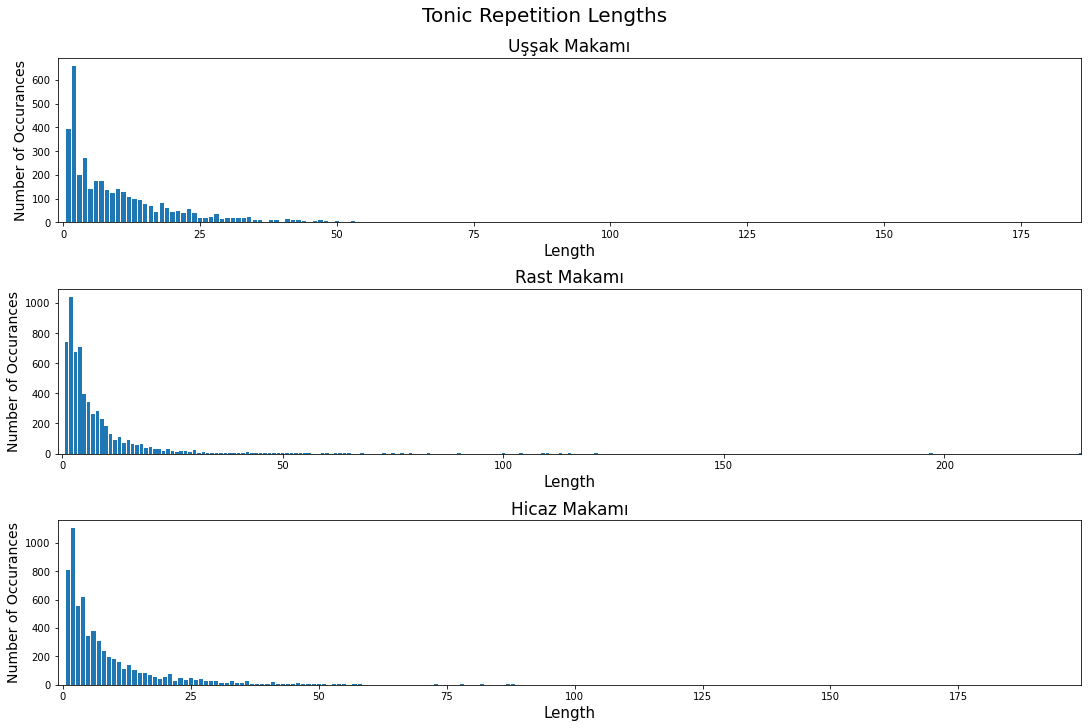

In [22]:
fig,ax=plt.subplots(3,1,figsize=(15,10), constrained_layout=True)
fig.suptitle(f'Tonic Repetition Lengths', fontsize=20)
makam='Uşşak'
ax[0].bar(return_to_tonic_durations[makam].keys(),return_to_tonic_durations[makam].values())
ax[0].set_xlim([-1, max(return_to_tonic_durations[makam].keys())])
ax[0].set_title(f'{makam} Makamı', fontsize=17)
makam='Rast'
ax[1].bar(return_to_tonic_durations[makam].keys(),return_to_tonic_durations[makam].values())
ax[1].set_xlim([-1, max(return_to_tonic_durations[makam].keys())])
ax[1].set_title(f'{makam} Makamı', fontsize=17)
makam='Hicaz'
ax[2].bar(return_to_tonic_durations[makam].keys(),return_to_tonic_durations[makam].values())
ax[2].set_xlim([-1, max(return_to_tonic_durations[makam].keys())])
ax[2].set_title(f'{makam} Makamı', fontsize=17)
for x in ax:
    x.set_xlabel('Length', fontsize=15)
    x.set_ylabel('Number of Occurances', fontsize=14)
plt.show()

In [23]:
# Calculate the average lengths by total composition length
av_return_to_tonic_durations={}
for makam,counter in return_to_tonic_durations.items():
    total_length=0
    for piece in subset[makam]: # get the total composition length
        total_length+=len(piece['notes'])
    av_return_to_tonic_durations[makam]=sum(counter)/total_length

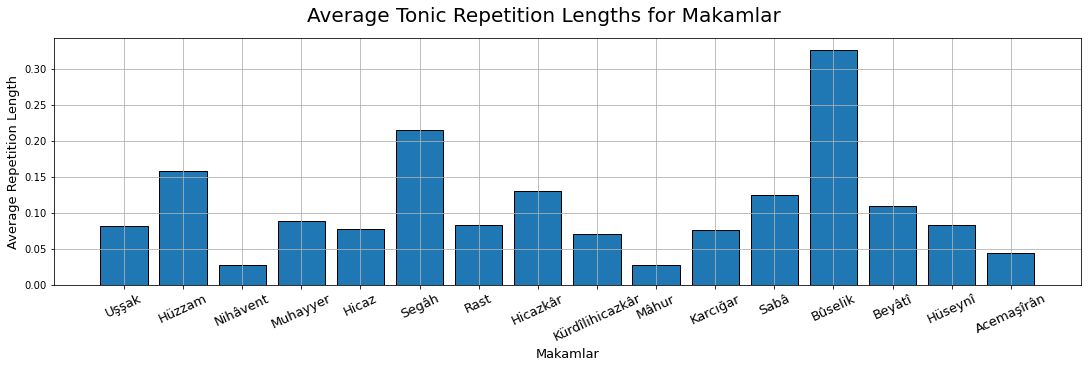

In [24]:
fig,ax=plt.subplots(figsize=(15,5), constrained_layout=True)
fig.suptitle('Average Tonic Repetition Lengths for Makamlar', fontsize=20) # More clever title?
ax.bar(av_return_to_tonic_durations.keys(),av_return_to_tonic_durations.values(),edgecolor='k')
ax.tick_params(axis='x', labelsize=13, rotation=25)
ax.set_xlabel('Makamlar', fontsize=13)
ax.set_ylabel('Average Repetition Length', fontsize=13)
ax.grid()
plt.show()

### Return to Tonic Pitch Ranges

In [25]:
return_to_tonic_ranges=defaultdict(Counter)
return_to_tonic_simple=defaultdict(list)
for makam, makam_dct in subset.items():
    for piece in makam_dct:
        ranges=find_return_to_tonic_ranges(piece)
        return_to_tonic_ranges[makam]+=Counter(ranges)
        return_to_tonic_simple[makam].extend(ranges)

**Some Examples**

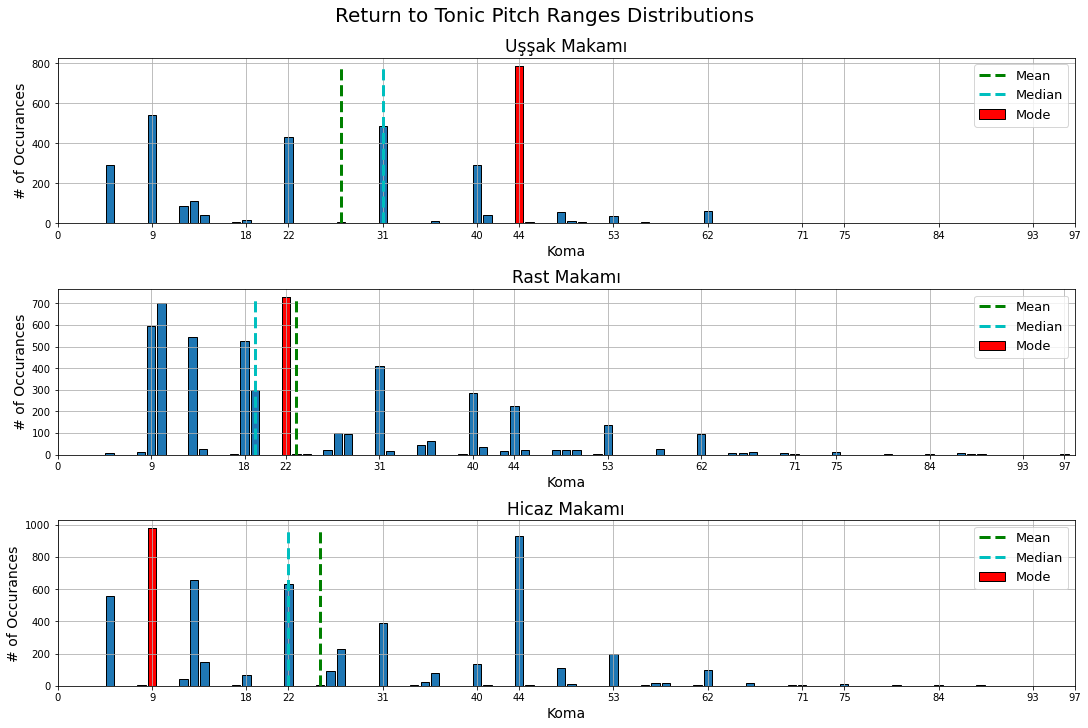

In [26]:
fig,ax=plt.subplots(3,1,figsize=(15,10), constrained_layout=True)
fig.suptitle(f'Return to Tonic Pitch Ranges Distributions', fontsize=20)
for i,makam in enumerate(['Uşşak','Rast','Hicaz']):
    
    makam_dict=return_to_tonic_ranges[makam]
    bins=np.array(list(makam_dict.keys()))
    values=np.array(list(makam_dict.values()))

    mean=int(np.mean(return_to_tonic_simple[makam]))
    mode, count =stats.mode(return_to_tonic_simple[makam])
    median=int(np.median(return_to_tonic_simple[makam]))
    mode_indicator=np.zeros(values.max())
    mode_indicator[mode]=count
    
    ax[i].bar(bins,values, edgecolor='k')  
    ax[i].bar(np.arange(values.max()), mode_indicator, color='r', edgecolor='k', label='Mode')
    ax[i].vlines(mean,0,count, linestyles='--', linewidths=3, color='g', label='Mean')
    ax[i].vlines(median,0,count, linestyles='--', linewidths=3, color='c', label='Median')
    ax[i].set_xlim([0, max(bins)+1])
    ax[i].set_xticks(list(PITCH_CLASS.values()) + [53+x for x in list(PITCH_CLASS.values())])
    ax[i].set_title(f'{makam} Makamı', fontsize=17)
    ax[i].set_xlabel('Koma', fontsize=14)
    ax[i].set_ylabel('# of Occurances', fontsize=14)
    ax[i].legend(loc=1, fontsize=13)
    ax[i].grid()
plt.show()

**Comparison Between all Makamlar in our subset**

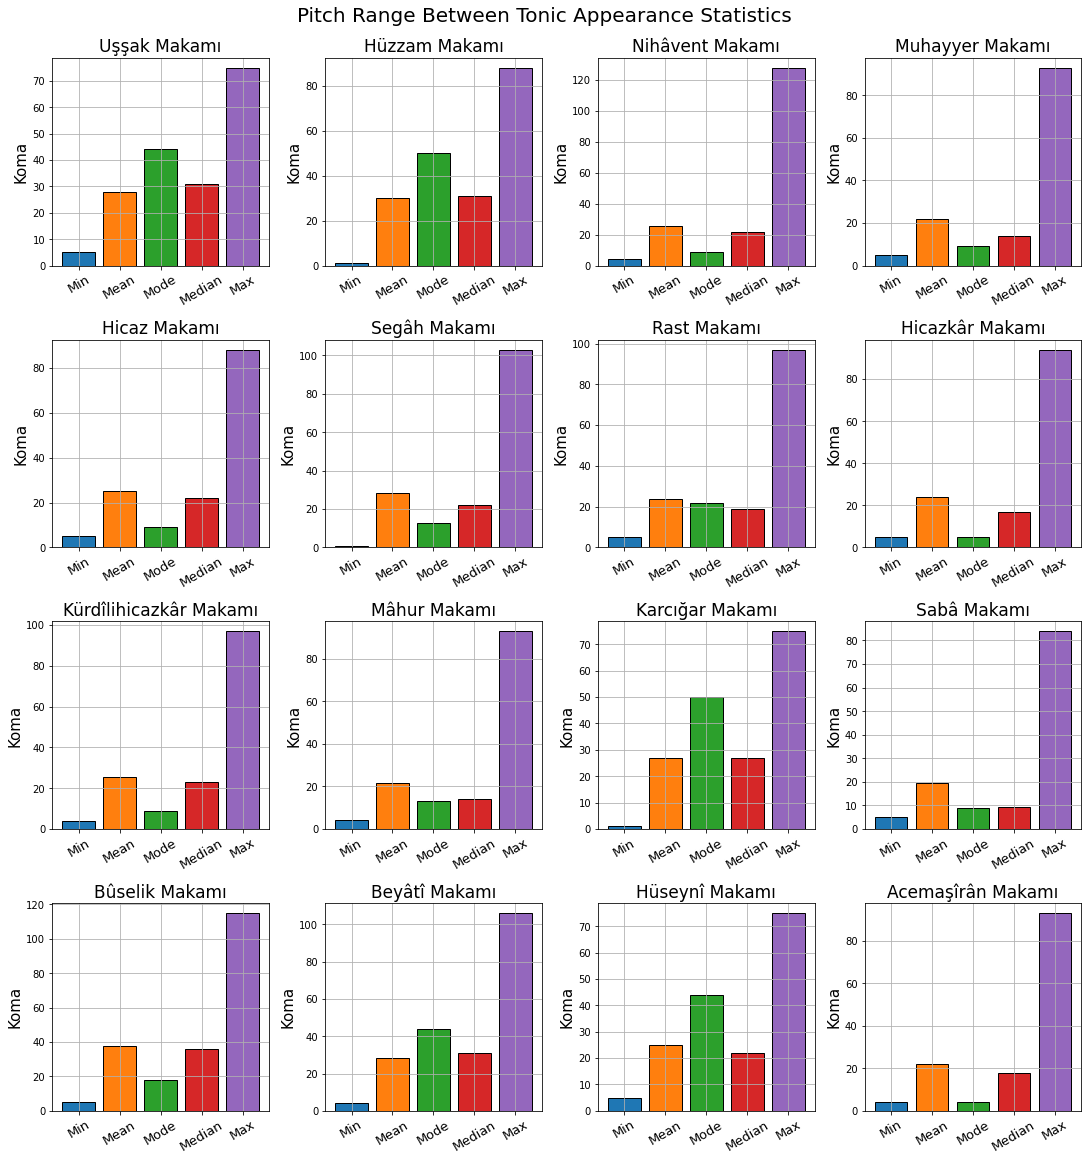

In [28]:
bar_names=['Min','Mean','Mode','Median','Max']
fig, axs = plt.subplots(4, 4, figsize = (15, 16),constrained_layout=True)
fig.suptitle('Pitch Range Between Tonic Appearance Statistics', fontsize=20)
for i,(makam,lst) in enumerate(return_to_tonic_simple.items()):
    mean=np.mean(lst)
    mode, count =stats.mode(lst)
    median=np.median(lst)
    min_=np.min(lst)
    max_=np.max(lst)    
    axs[i//4][i%4].bar('Min', min_, edgecolor='k')
    axs[i//4][i%4].bar('Mean', mean, edgecolor='k')
    axs[i//4][i%4].bar('Mode', mode, edgecolor='k')
    axs[i//4][i%4].bar('Median', median, edgecolor='k')
    axs[i//4][i%4].bar('Max', max_, edgecolor='k')
    
    axs[i//4][i%4].set_title(f'{makam} Makamı', fontsize=17)
    axs[i//4][i%4].set_ylabel('Koma', fontsize=15)
    axs[i//4][i%4].tick_params(axis='x', which='major', labelsize=13, rotation=30)
    axs[i//4][i%4].grid()    